**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [3]:
df["median_house_value"] = np.log1p(df["median_house_value"])

In [4]:
X = df[df.columns.difference(["median_house_value"])]
y = df["median_house_value"]
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)
X_train.shape, X_val.shape, X_test.shape

((12384, 9), (4128, 9), (4128, 9))

In [5]:
for df_ in [X_train, X_val, X_test]:
    df_.reset_index(drop=True)

- We will use `DictVectorizer` to turn train and validation into matrices.

In [6]:
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')

In [7]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [8]:
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [9]:
dv.get_feature_names()

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

- Answer: **ocean_proximity=INLAND**

## Question 2

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [12]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_val = rf.predict(X_val)

In [13]:
mean_squared_error(y_pred_val, y_val, squared=False)

0.2457383433183843

- What's the RMSE of this model on validation?

- Answer: **0.25**

## Question 3

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [14]:
n_estimators_list = np.arange(10, 201, 10)
n_estimators_list

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

In [18]:
pred_scores = {}
for n_estimator in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n_estimator, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_val = rf.predict(X_val)
    pred_scores[n_estimator] = round(mean_squared_error(y_pred_val, y_val, squared=False), 3)

In [19]:
display(pred_scores)

{10: 0.246,
 20: 0.239,
 30: 0.236,
 40: 0.235,
 50: 0.233,
 60: 0.233,
 70: 0.232,
 80: 0.233,
 90: 0.232,
 100: 0.232,
 110: 0.232,
 120: 0.232,
 130: 0.232,
 140: 0.232,
 150: 0.232,
 160: 0.232,
 170: 0.232,
 180: 0.232,
 190: 0.232,
 200: 0.232}

No handles with labels found to put in legend.


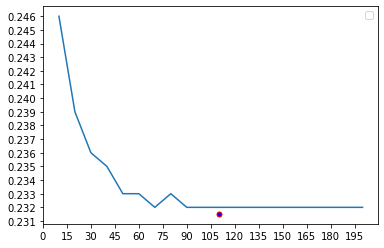

In [20]:
plt.plot(pred_scores.keys(), pred_scores.values())
plt.plot(110, 0.23151835138763843, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="blue")
plt.xticks(np.arange(0, max(pred_scores.keys())+10, 15))
plt.yticks(np.arange(0.231, max(pred_scores.values())+0.001, 0.001))
plt.legend()
plt.show()

- After which value of `n_estimators` does RMSE stop improving?

- Answer: **150**

## Question 4

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [18]:
max_depth_list = np.arange(10, 26, 5)
max_depth_list

array([10, 15, 20, 25])

In [19]:
scores = []
for max_depth in max_depth_list:
    for n_estimator in n_estimators_list:
        rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimator, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred_val = rf.predict(X_val)
        score = mean_squared_error(y_pred_val, y_val, squared=False)
        scores.append((max_depth, n_estimator, score)) 
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'RMSE'])

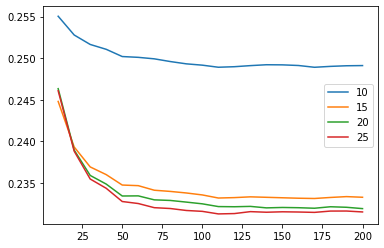

In [20]:
for max_depth in max_depth_list:
    df_temp = df_scores[df_scores["max_depth"] == max_depth]
    plt.plot(df_temp.n_estimators, df_temp.RMSE, label=max_depth)
plt.legend()
plt.show()

- What's the best `max_depth`:

- Answer: **25**

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [21]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [23]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by="importance")

,feature,importance
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000449
5,ocean_proximity=<1H OCEAN,0.003007
9,ocean_proximity=NEAR OCEAN,0.004228
0,households,0.016957
11,total_bedrooms,0.019041
12,total_rooms,0.020536
10,population,0.030918
1,housing_median_age,0.033094
3,longitude,0.096265


- What's the most important feature?

- Answer: **median_income**

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [24]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [25]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [26]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [42]:
%%capture model_output
xgb_params = {  
    # how fast our model learns
    'eta': 0.3,  
    'max_depth': 6,  
    # how many observations we need to have in a leaf node
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=100,
                  evals=watchlist)

In [43]:
df_eta03 = parse_xgb_output(model_output)

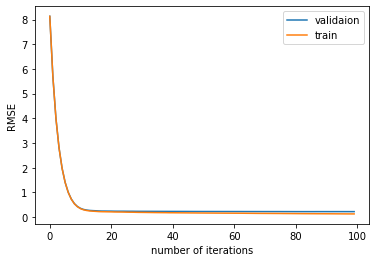

In [44]:
plt.plot(df_eta03.num_iter, df_eta03.val_rmse, label="validaion")
plt.plot(df_eta03.num_iter, df_eta03.train_rmse, label="train")

plt.ylabel("RMSE")
plt.xlabel("number of iterations")
plt.legend()
plt.show()

- Now, change eta first to 0.1 and then to 0.01.

In [45]:
%%capture model_output
xgb_params = {  
    # how fast our model learns
    'eta': 0.1,  
    'max_depth': 6,  
    # how many observations we need to have in a leaf node
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=100,
                  evals=watchlist)

In [46]:
df_eta01 = parse_xgb_output(model_output)

In [47]:
%%capture model_output
xgb_params = {  
    # how fast our model learns
    'eta': 0.01,  
    'max_depth': 6,  
    # how many observations we need to have in a leaf node
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params,
                  dtrain,
                  num_boost_round=100,
                  evals=watchlist)

In [48]:
df_eta001 = parse_xgb_output(model_output)

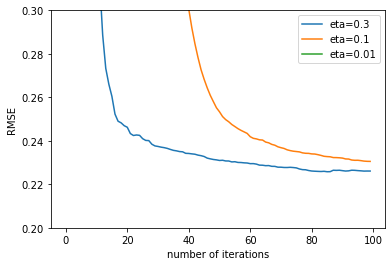

In [50]:
plt.plot(df_eta03.num_iter, df_eta03.val_rmse, label="eta=0.3")
plt.plot(df_eta01.num_iter, df_eta01.val_rmse, label="eta=0.1")
plt.plot(df_eta001.num_iter, df_eta001.val_rmse, label="eta=0.01")

plt.ylabel("RMSE")
plt.xlabel("number of iterations")
plt.ylim(0.2,0.3)
plt.legend()
plt.show()

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: **eta=0.3**

In [70]:
!git push origin master

To https://github.com/Kibzik/mlbookcamp-code
   20a014a..7ef2bc8  master -> master
